In [51]:
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [52]:
def exponentiated_quadratic(xa, xb, length_scale=1):
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

n = 50  
num_f = 10  

X = np.expand_dims(np.linspace(-4, 4, n), 1)
# Kernel based on the datapoints
sigma = exponentiated_quadratic(X, X)

# Sample the prior at X
y = np.random.multivariate_normal(mean=np.zeros(n), cov=sigma, size=num_f)

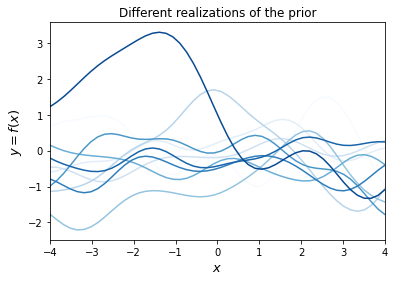

In [166]:
plt.figure(figsize=(6, 4))
cmap = matplotlib.colormaps.get_cmap('Blues')
colors = [cmap(i/num_f) for i in range(num_f)]

for i in range(num_f):
    plt.plot(X, y[i], linestyle='-', color=colors[i])
    
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title('Different realizations of the prior')
plt.xlim([-4, 4])
plt.show()

f_star-2*var_f_starThe algorithm as defined in 'Gaussian Processes for Machine Learning':

$$
\begin{array}{l}
\textbf{Gaussian Process} \\
\textbf{input: } X \text{ (inputs)}, y \text{ (targets)}, k \text{ (covariance function)}, \sigma_n^2 \text{ (noise level)}, x_* \text{ (test input)} \\
\quad L := \text{cholesky}(K + \sigma_n^2 I) \\
\quad \alpha := L^T \backslash (L \backslash y) \\
\quad f_* := k_*^T \alpha \quad \textit{(predictive mean)} \\
\quad v := L \backslash k_* \\
\quad \mathbb{V}[f_*] := k(x_*, x_*) - v^T v \quad \textit{(predictive variance)} \\
\quad \log p(y | X) := -\frac{1}{2} y^T \alpha - \sum_i \log L_{ii} - \frac{n}{2} \log 2\pi \\
\quad \textbf{return } f_*, \mathbb{V}[f_*], \log p(y | X) \text{ (log marginal likelihood)}
\end{array}
$$

In [162]:
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # training points
n2 = 75  # test points
ny = 5  # funcs to sample from posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)

X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)

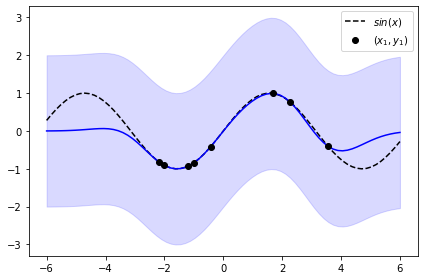

In [165]:
noise_sigma = 0.35

#### Fitting
K = exponentiated_quadratic(X1, X1) #+ (noise_sigma ** 2) * np.eye(n1)
L = scipy.linalg.cholesky(K, lower=True)
alpha = scipy.linalg.cho_solve((L, True), y1)
####

#### Test samples 
k_star = exponentiated_quadratic(X1, X2)
f_mean = k_star.T.dot(alpha) # Mean

v = scipy.linalg.cho_solve((L, True), k_star)
f_cov = exponentiated_quadratic(X2, X2) #- v.T.dot(v)
####

var = np.sqrt(np.diag(f_cov))

plt.plot(X2, f_sin(X2), 'k--', label='$sin(x)$')
plt.plot(X2[:, 0], f_mean, color='b')
plt.fill_between(X2[:, 0].flat, f_mean-2*var, f_mean+2*var, color='b', alpha=0.15)

plt.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
plt.legend()

plt.tight_layout()